In [8]:
!pip install emd


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.1/83.1 KB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 61.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 KB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.0/81.0 KB 7.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4


KeyboardInterrupt: ignored

<AxesSubplot:xlabel='Time (samples)'>

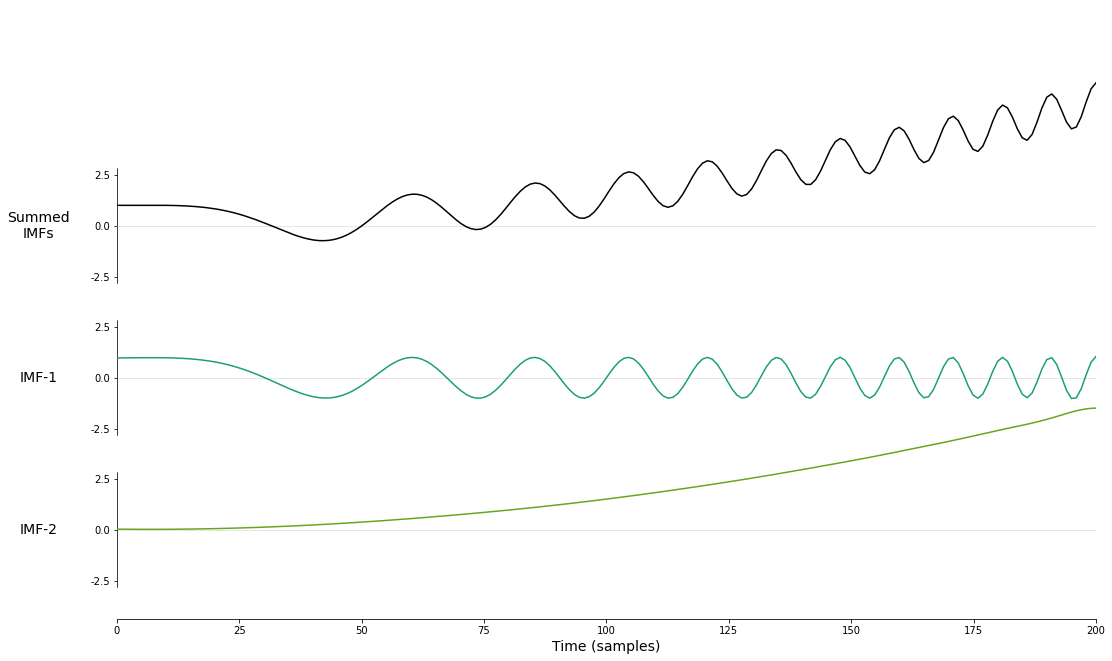

In [4]:
import emd 
import numpy  as np
import pylab as plt
# Define signal
t = np.linspace(0, 1, 200)
s = np.cos(11*2*np.pi*t*t) + 6*t*t
imf=emd.sift.sift(s)

emd.plotting.plot_imfs(imf)

Text(0.5, 0, 'Samples')

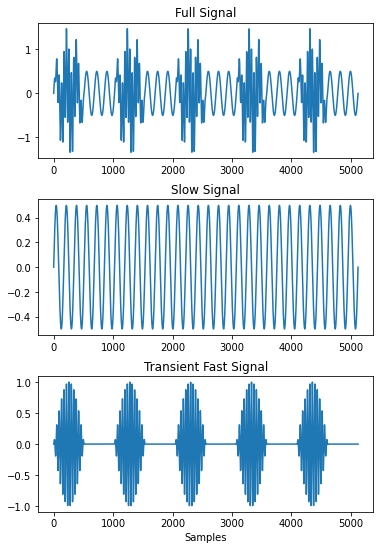

In [5]:
seconds = 5
sample_rate = 1024
time_vect = np.linspace(0, seconds, seconds*sample_rate)

# Create an amplitude modulation
am = np.sin(2*np.pi*time_vect)
am[am < 0] = 0

# Create a 25Hz signal and introduce the amplitude modulation
xx = am*np.sin(2*np.pi*25*time_vect)

# Create a non-modulated 6Hz signal
yy = .5*np.sin(2*np.pi*6*time_vect)

# Sum the 25Hz and 6Hz components together
xy = xx+yy

# Make a quick summary plot
plt.figure(figsize=(6,9))
plt.subplots_adjust(hspace=0.3)
plt.subplot(311)
plt.plot(xy)
plt.title('Full Signal')
plt.subplot(312)
plt.plot(yy)
plt.title('Slow Signal')
plt.subplot(313)
plt.plot(xx)
plt.title('Transient Fast Signal')
plt.xlabel('Samples')

# sphinx_gallery_thumbnail_number = 2

Normal EMD on the slow+fast transient signals

<AxesSubplot:xlabel='Time (samples)'>

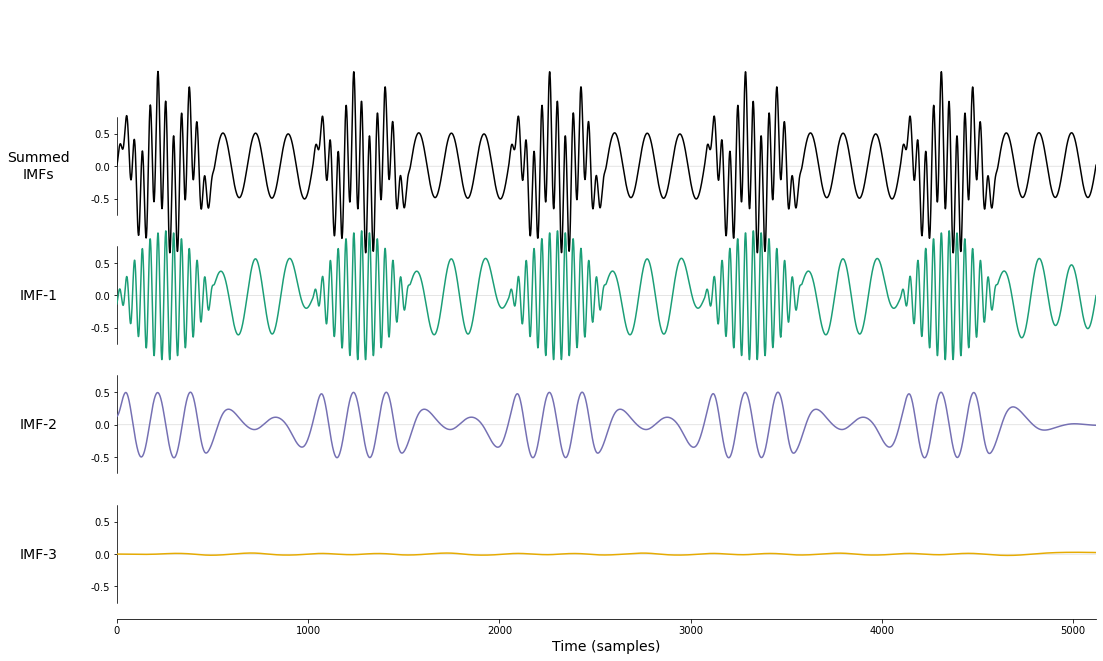

In [6]:
imf = emd.sift.sift(xy, max_imfs=3)
emd.plotting.plot_imfs(imf)

MASK EMD:

The signals are well separated when both oscillations are present. However in time periods where the fast 25Hz signal disappears the slower signal jumps up to become part of the fast component. We’d prefer the separation into narrow band components as seen in the simulations above…

This happens as EMD is a locally adaptive algorithm - the peaks and troughs in the signal define the time-scales that are analysed for a given part of the signal. So, the first IMF will always find the fastest peaks for every part of the signal even if the definition of ‘fast’ might be different in different segments.

The masked sift is a potential solution to this problem. This is a simple trick which effectively puts a lower bound on the frequency content that can enter a particular IMF.

Any signals which are lower in frequency than this mask should then be ignored by the sift in favour of this known signal. Finally, we can remove the known mask to recover our IMF.

Here we make a 30Hz mask and plot it next to a segment of our time-series.

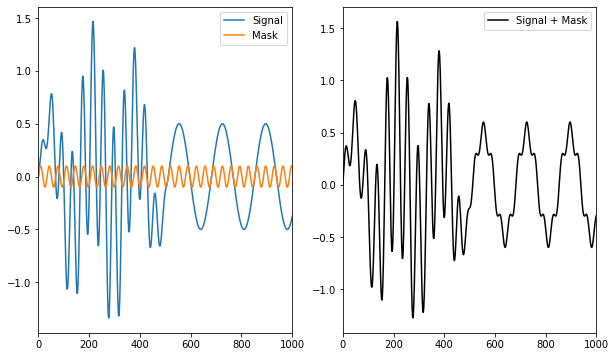

In [7]:
mask = 0.1*np.sin(2*np.pi*30*time_vect)

plt.figure(figsize=(10, 6))
plt.subplot(121)
plt.plot(xy)
plt.plot(mask)
plt.legend(['Signal', 'Mask'])
plt.xlim(0, 1000)
plt.subplot(122)
plt.plot(xy + mask, color='k')
plt.xlim(0, 1000)
plt.legend(['Signal + Mask'])

In [8]:
imf_raw, _ = emd.sift.get_next_imf(xy)
imf_mask, _ = emd.sift.get_next_imf(xy+mask)

Text(0.5, 1.0, 'Masked IMF with Mask removed')

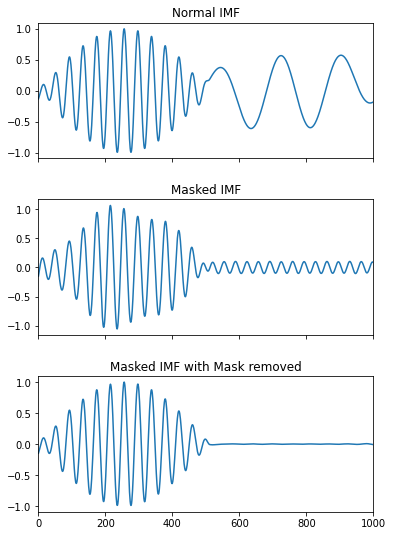

In [9]:
plt.figure(figsize=(6,9))
plt.subplots_adjust(hspace=0.3)
plt.subplot(311)
plt.plot(imf_raw)
plt.xlim(0, 1000)
plt.title('Normal IMF')
plt.gca().set_xticklabels([])
plt.subplot(312)
plt.plot(imf_mask)
plt.xlim(0, 1000)
plt.title('Masked IMF')
plt.gca().set_xticklabels([])
plt.subplot(313)
plt.plot(imf_mask - mask[:, np.newaxis])
plt.xlim(0, 1000)
plt.title('Masked IMF with Mask removed')

The normal IMF in the top panel has the problem we saw earlier, the slow signal is leaking into the fast IMF. The masked IMF successfully suppresses this slow signal, replacing it with the mask frequency. Finally, subtracting the mask removes everything but the 25Hz oscillation which now correctly disappears between bursts.

Text(0.5, 1.0, 'Masked IMF with Mask removed')

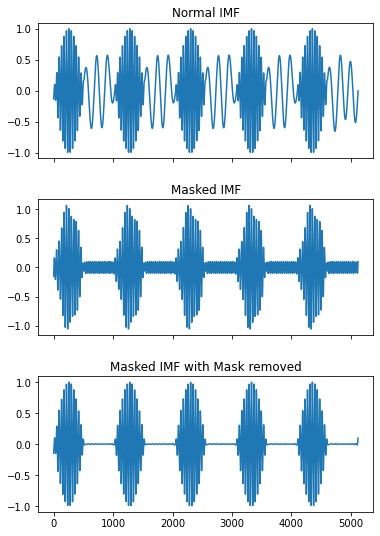

In [10]:
plt.figure(figsize=(6, 9))
plt.subplots_adjust(hspace=0.3)
plt.subplot(311)
plt.plot(imf_raw)
plt.title('Normal IMF')
plt.gca().set_xticklabels([])
plt.subplot(312)
plt.plot(imf_mask)
plt.title('Masked IMF')
plt.gca().set_xticklabels([])
plt.subplot(313)
plt.plot(imf_mask - mask[:, np.newaxis])
plt.title('Masked IMF with Mask removed')

[30.   15.    7.5   3.75]


<AxesSubplot:xlabel='Time (samples)'>

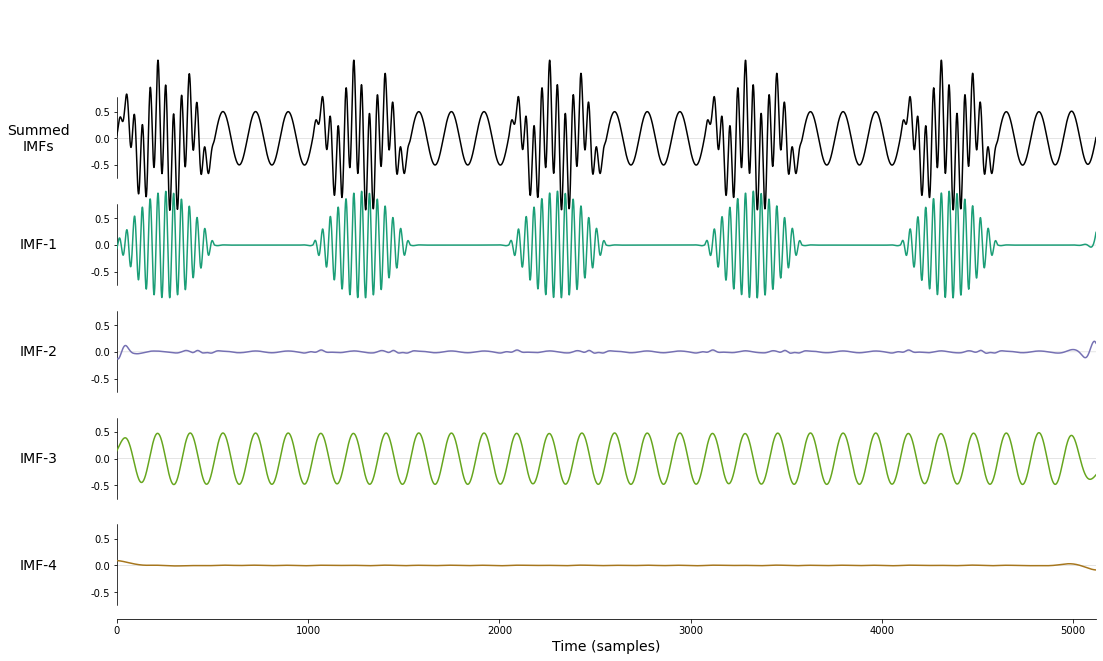

In [11]:
imf, mask_freqs = emd.sift.mask_sift(xy, mask_freqs=30/sample_rate, ret_mask_freq=True, max_imfs=4)

print(mask_freqs * sample_rate)

emd.plotting.plot_imfs(imf)

**Iterated Masked sifting:**

Masking signals are a powerful method for reducing the mode mixing problem when running EMD on noisy or transient signals. However, the standard methods for selecting masks often perform poorly in real data and selecting masks by hand can be cumbersome and prone to error.

This tutorial interoduces iterated masking EMD (itEMD), a recent sifting method that automates mask signal frequencies based on the dynamics present in the data. We will show how it automatically dentifies oscillations and minimises mode mixing without prespecification of masking signals.

The method is published in the following paper:

Marco S. Fabus, Andrew J. Quinn, Catherine E. Warnaby, and Mark W. Woolrich (2021). Automatic decomposition of electroptysiological data into distinct nonsinusoidal oscillatory modes. Journal of Neurophysiology 2021 126:5, 1670-1684. https://doi.org/10.1152/jn.00315.2021

Let’s start by simulating a signal with a 2Hz nonsinusoidal oscillation and 30Hz beta bursts

(0.0, 3.0)

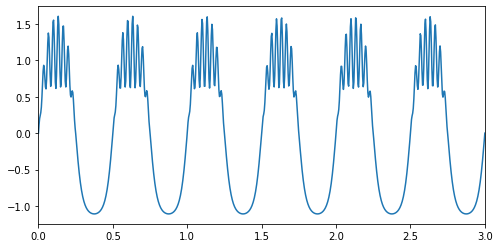

In [13]:

np.random.seed(0)
sample_rate = 256
seconds = 3
num_samples = sample_rate*seconds

time_vect = np.linspace(0, seconds, num_samples)

# Create an amplitude modulation
freq = 2
am = np.sin(2*np.pi*freq*time_vect)
am[am < 0] = 0

# Non-sinusoidal intermittend 2Hz signal
x1 = np.sin(np.sin(np.sin(np.sin(np.sin(np.sin(np.sin(2*np.pi*freq*time_vect))))))) / 0.5

# Bursting 30Hz oscillation
x2 = am *  0.5 * np.cos(2*np.pi*30*time_vect)

# Sum them together
x = x1 + x2

# Quick summary figure
plt.figure(figsize=(8, 4))
plt.plot(time_vect, x)
plt.xlim(0,  3)

# sphinx_gallery_thumbnail_number = 6

Running normal mask emd on the signal

<AxesSubplot:xlabel='Time (samples)'>

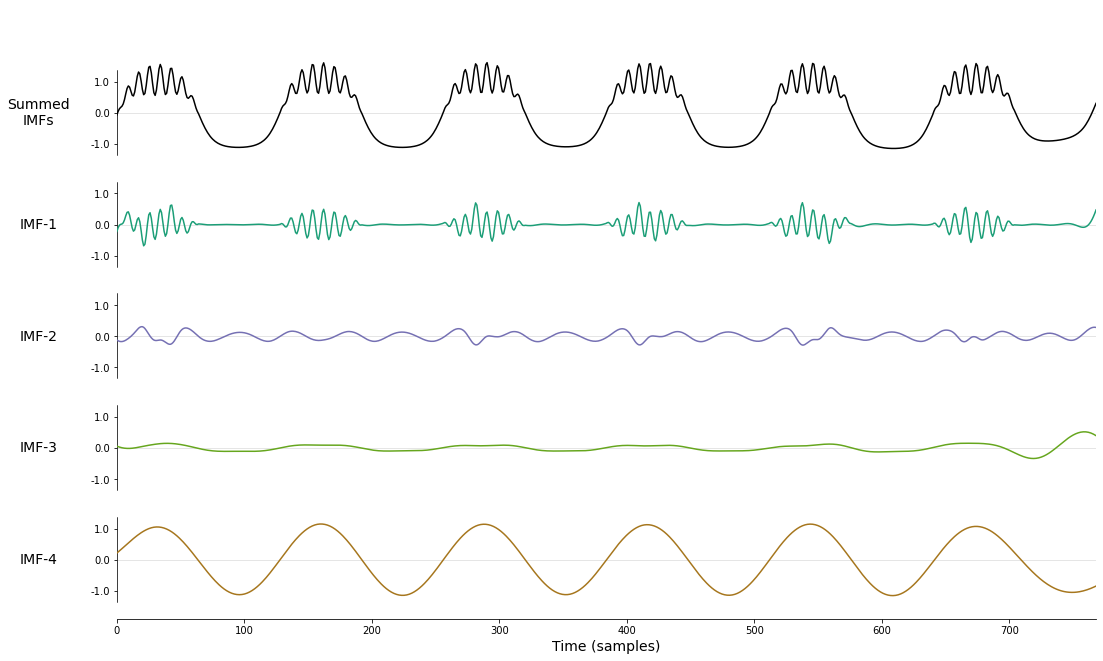

In [14]:
imf = emd.sift.mask_sift(x, max_imfs=4)
emd.plotting.plot_imfs(imf)

We can see that the result is not great. Bursting beta is in IMF-1, but the non-sinusoidal oscillation is split between IMF-2 and IMF-4. This is because the waveform is highly non-sinusoidal and spans a lot of frequencies, confusing the default mask sift. Let’s try the same thing, but now with custom mask frequencies.

<AxesSubplot:xlabel='Time (samples)'>

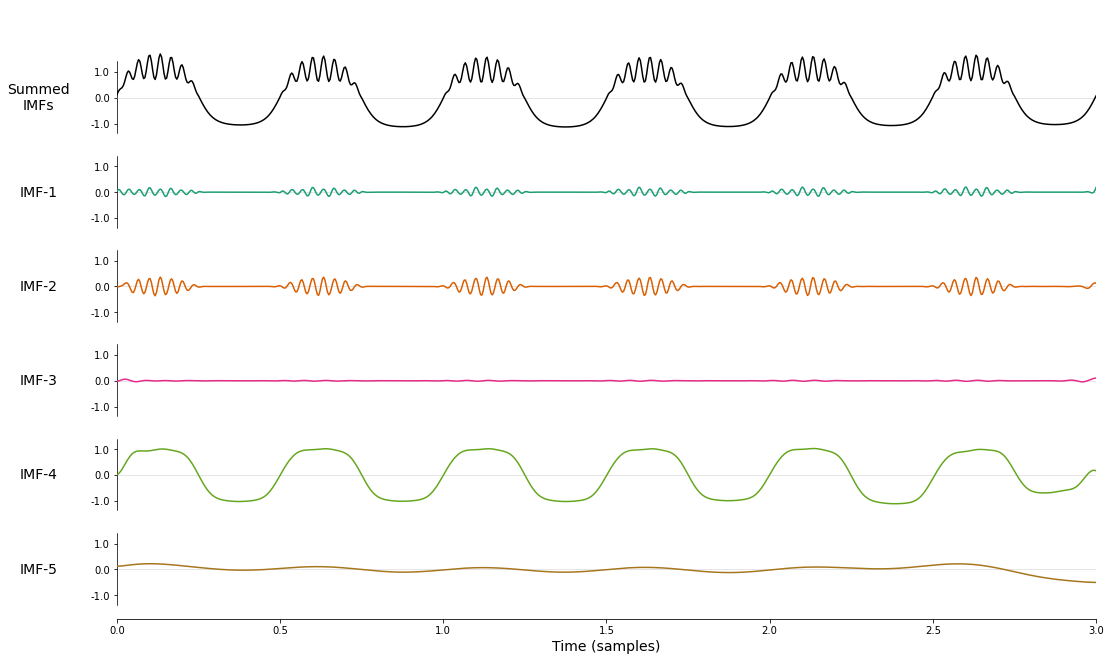

In [15]:
mask = np.array([60, 30, 24, 2, 1, 0.5])/sample_rate
imf = emd.sift.mask_sift(x, max_imfs=5, mask_freqs=mask)
emd.plotting.plot_imfs(imf, time_vect=time_vect)

Better! Most of the 2Hz oscillation is now in IMF-4 and most of bursting beta in IMF-2. However, it’s still not perfect - beta is slightly split between IMF-1 and IMF-2 and we have an unnecessary ‘empty’ mode IMF-3. Finding a mask that balances all of these issues can be an arduous manual process. How could we do this automatically? Let’s come back to our original sift and look at the mean instantaneous frequencies of the modes weighted by instantaneous amplitude.

In [16]:
imf = emd.sift.mask_sift(x, max_imfs=4)
IP,IF,IA = emd.spectra.frequency_transform(imf, sample_rate, 'nht')
print(np.average(IF, 0, weights=IA**2))

[27.04427481  6.20693296  1.63994241  1.9635715 ]


**Automated Mask Selection:**

Even though the modes are split, frequencies of the first two modes are close to the ground truths of 30Hz and 2Hz that we know. What happens if we take these frequencies as the mask for masked sift?

<AxesSubplot:xlabel='Time (samples)'>

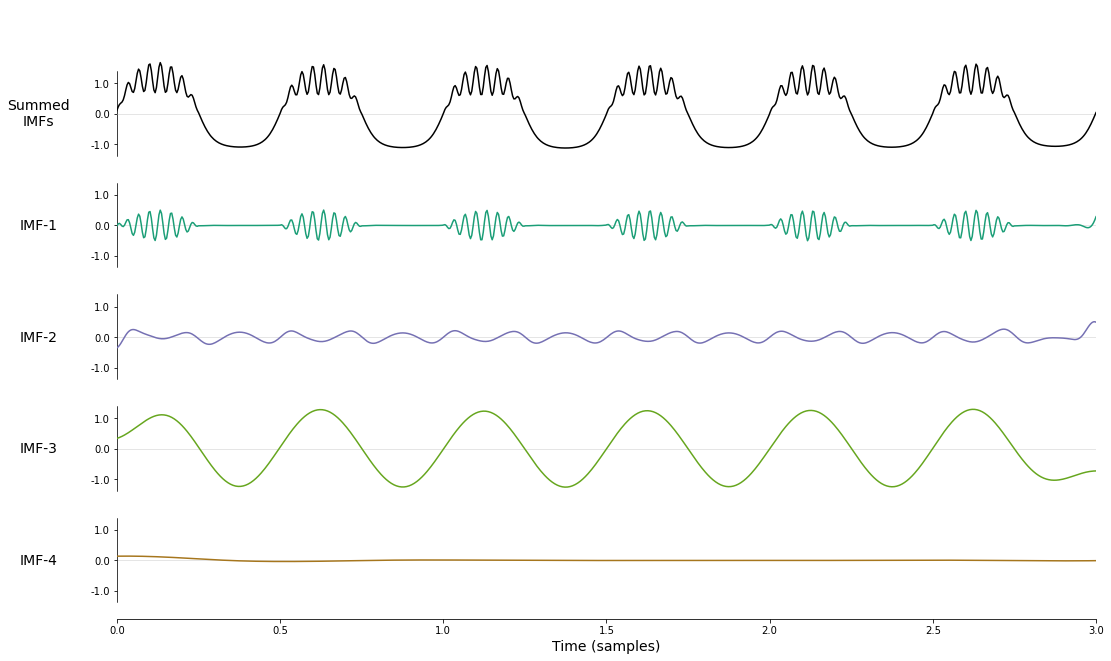

In [17]:
# Compute the default mask sift
imf = emd.sift.mask_sift(x, max_imfs=4)

# Take the mean IF as new mask, compute mask sift again and plot
IP,IF,IA = emd.spectra.frequency_transform(imf, sample_rate, 'nht')
mask_1 = np.average(IF, 0, weights=IA**2) / sample_rate
imf = emd.sift.mask_sift(x, max_imfs=4, mask_freqs=mask_1)
emd.plotting.plot_imfs(imf, time_vect=time_vect)

We have now removed the empty mode and the bursting beta in is entirely IMF-1. It’s certainly an improvement on the default sift. Let’s repeat this process ten times and track what happens to average frequencies of the first two IMFs.

/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:1585: RuntimeWarning: invalid value encountered in remainder
  ddmod = mod(dd - interval_low, period) + interval_low


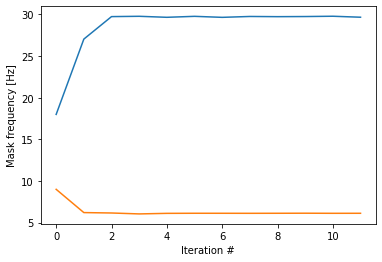

In [18]:
# Compute the default mask sift
imf, mask_0 = emd.sift.mask_sift(x, max_imfs=4, ret_mask_freq=True)

# Take the mean IF as new mask, compute mask sift again and plot
IP,IF,IA = emd.spectra.frequency_transform(imf, sample_rate, 'nht')
mask = np.average(IF, 0, weights=IA**2) / sample_rate

# Save all masks:
mask_all = np.zeros((3, 12))
mask_all[:, 0] = mask_0[:3]
mask_all[:, 1] = mask[:3]

for i in range(10):
    imf = emd.sift.mask_sift(x, max_imfs=4, mask_freqs=mask)
    IP,IF,IA = emd.spectra.frequency_transform(imf, sample_rate, 'nht')
    mask = np.average(IF, 0, weights=IA**2) / sample_rate
    mask_all[:, i+2] = mask[:3]

plt.figure()
for i in range(2):
    plt.plot(mask_all[i, :]*sample_rate)
plt.xlabel('Iteration #')
plt.ylabel('Mask frequency [Hz]')
plt.show()

The iteration process rapidly converged on the ground truth frequencies, 2Hz and 30Hz! This is the essence of iterated masking EMD (itEMD). By finding the equilibrium between masks and IMF frequencies, we automatically extract oscillations of interest in a data-driven way. Let’s apply itEMD directly and show the result.

<AxesSubplot:xlabel='Time (samples)'>

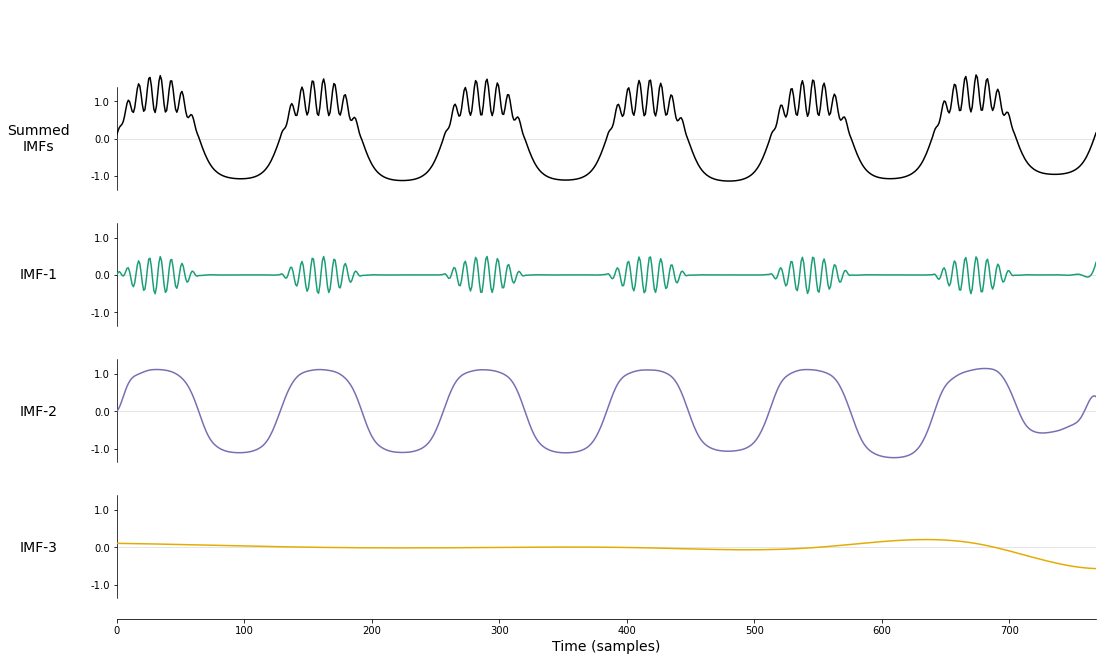

In [19]:
imf = emd.sift.iterated_mask_sift(x, sample_rate=sample_rate, max_imfs=3)
emd.plotting.plot_imfs(imf)